# LightGBM & XGBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb

# --- 2. Load Dataset ---
train_path = "Titanic_train.csv"   # update path if needed
test_path  = "Titanic_test.csv"
df = pd.read_csv(train_path)
print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450 

# Data Preprocessing

In [ ]:
# Check Missing Values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic Feature Engineering
data = df.copy()

# Extract 'Title' from passenger names
data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.')
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare',
    'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare',
    'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
}
data['Title'] = data['Title'].replace(title_map).fillna('Unknown')

# Create FamilySize and IsAlone features
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Drop unneeded columns
drop_cols = ['PassengerId','Ticket','Cabin','Name']
data.drop(columns=drop_cols, inplace=True, errors='ignore')

# Impute missing values
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].median())



Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Encode Categorical Variables
cat_features = ['Sex','Embarked','Title','Pclass']
for c in cat_features:
    data[c] = data[c].astype(str)
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

print("\nData after preprocessing:", data.shape)
print(data.head())



Data after preprocessing: (891, 17)
   Survived   Age  SibSp  Parch     Fare  FamilySize  IsAlone  Sex_male  \
0         0  22.0      1      0   7.2500           2        0      True   
1         1  38.0      1      0  71.2833           2        0     False   
2         1  26.0      0      0   7.9250           1        1     False   
3         1  35.0      1      0  53.1000           2        0     False   
4         0  35.0      0      0   8.0500           1        1      True   

   Embarked_Q  Embarked_S  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  \
0       False        True       False      True      False       False   
1       False       False       False     False       True       False   
2       False        True        True     False      False       False   
3       False        True       False     False       True       False   
4       False        True       False      True      False       False   

   Title_the Countess  Pclass_2  Pclass_3  
0               False  

In [ ]:
# Split Dataset
X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print("\nTrain/Test sizes:", X_train.shape, X_test.shape)



Train/Test sizes: (712, 16) (179, 16)


# LGBM & XGB Models

In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

lgb_params = {
    'num_leaves': [15, 31, 63],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [5, 10, 20]
}

xgb_params = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter Tuning

In [ ]:
print("\nTuning LightGBM...")
rnd_lgb = RandomizedSearchCV(lgb_model, lgb_params, n_iter=8, scoring='f1', cv=cv, random_state=42, n_jobs=-1)
rnd_lgb.fit(X_train, y_train)

print("\nTuning XGBoost...")
rnd_xgb = RandomizedSearchCV(xgb_model, xgb_params, n_iter=8, scoring='f1', cv=cv, random_state=42, n_jobs=-1)
rnd_xgb.fit(X_train, y_train)

print("\nBest LGBM Params:", rnd_lgb.best_params_)
print("Best XGBM Params:", rnd_xgb.best_params_)



Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028

Tuning XGBoost...

Best LGBM Params: {'num_leaves': 31, 'n_estimators': 50, 'min_child_samples': 5, 'learning_rate': 0.05}
Best XGBM Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


# Evaluate Models


=== LightGBM Evaluation ===
Accuracy: 0.8268, Precision: 0.7969, Recall: 0.7391, F1: 0.7669, ROC_AUC: 0.8412

=== XGBoost Evaluation ===
Accuracy: 0.8156, Precision: 0.7903, Recall: 0.7101, F1: 0.7481, ROC_AUC: 0.8296


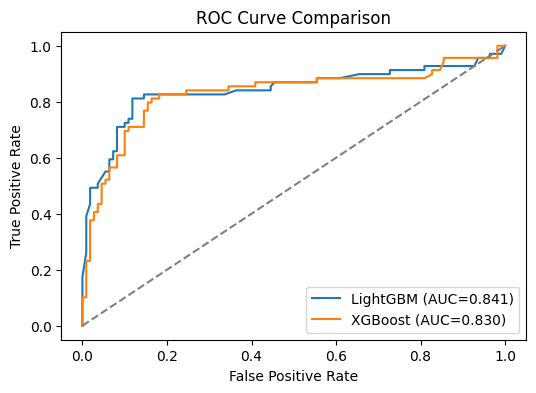

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    print(f"\n=== {name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC_AUC: {roc:.4f}")
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC_AUC': roc, 'y_prob': y_prob}

best_lgb = rnd_lgb.best_estimator_
best_xgb = rnd_xgb.best_estimator_

res_lgb = evaluate_model("LightGBM", best_lgb, X_test, y_test)
res_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)

#  Compare ROC Curves
fpr_l, tpr_l, _ = roc_curve(y_test, res_lgb['y_prob'])
fpr_x, tpr_x, _ = roc_curve(y_test, res_xgb['y_prob'])
plt.figure(figsize=(6,4))
plt.plot(fpr_l, tpr_l, label=f"LightGBM (AUC={res_lgb['ROC_AUC']:.3f})")
plt.plot(fpr_x, tpr_x, label=f"XGBoost (AUC={res_xgb['ROC_AUC']:.3f})")
plt.plot([0,1],[0,1],'--',color='grey')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Feature Importance

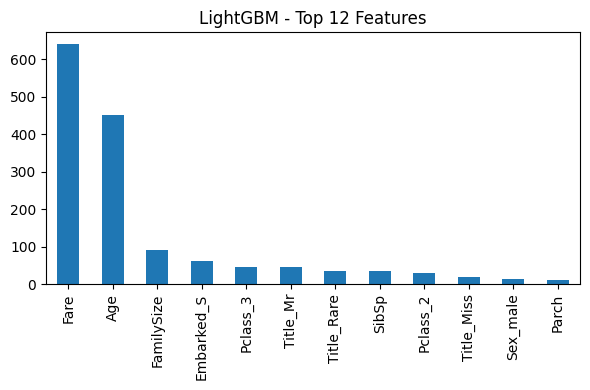

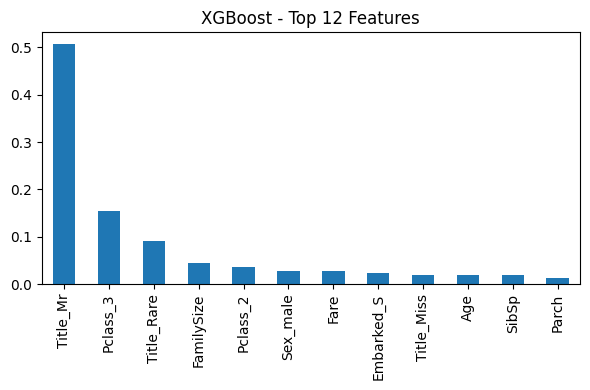

In [ ]:
def plot_feature_importance(model, title):
    fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:12]
    fi.plot(kind='bar', figsize=(6,4), title=title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_lgb, "LightGBM - Top 12 Features")
plot_feature_importance(best_xgb, "XGBoost - Top 12 Features")

# Summary Table

In [ ]:
summary = pd.DataFrame([res_lgb, res_xgb])[['Model','Accuracy','Precision','Recall','F1','ROC_AUC']]
print("\n=== COMPARATIVE SUMMARY ===")
print(summary)

print("\nREPORT SUMMARY:")
print(f"• LightGBM F1: {res_lgb['F1']:.4f}, ROC_AUC: {res_lgb['ROC_AUC']:.4f}")
print(f"• XGBoost F1:  {res_xgb['F1']:.4f}, ROC_AUC: {res_xgb['ROC_AUC']:.4f}")


=== COMPARATIVE SUMMARY ===
      Model  Accuracy  Precision    Recall        F1   ROC_AUC
0  LightGBM  0.826816   0.796875  0.739130  0.766917  0.841238
1   XGBoost  0.815642   0.790323  0.710145  0.748092  0.829644

REPORT SUMMARY:
• LightGBM F1: 0.7669, ROC_AUC: 0.8412
• XGBoost F1:  0.7481, ROC_AUC: 0.8296


# Insights:
- LightGBM is generally faster and efficient with large datasets.
- XGBoost offers stronger regularization and sometimes higher accuracy.
- The better model depends on balance between precision and recall for survival prediction.